开始SiO2数据集对比分析...
✓ 成功加载所有SiO2数据集

SiO2数据集基本信息对比

v=1 数据集:
  - 数据形状: (6000, 16)
  - 波数范围: 0 - 5999 cm⁻¹
  - 温度列数: 15
  - 温度范围: 100 - 1500 K
  - 数值范围: 2.27e-47 - 1.27e-17
  - 平均值: 6.07e-21

v=10 数据集:
  - 数据形状: (601, 31)
  - 波数范围: 0 - 6000 cm⁻¹
  - 温度列数: 30
  - 温度范围: 100 - 3000 K
  - 数值范围: 3.63e-45 - 1.71e-18
  - 平均值: 5.65e-21

v=20 数据集:
  - 数据形状: (301, 21)
  - 波数范围: 0 - 6000 cm⁻¹
  - 温度列数: 20
  - 温度范围: 100 - 2000 K
  - 数值范围: 6.98e-44 - 8.49e-19
  - 平均值: 5.95e-21

数据预处理

处理 v=1 数据集...
  ✓ v=1: 训练数据 90000 行

处理 v=10 数据集...
  ✓ v=10: 训练数据 16227 行
    测试数据 1803 行

处理 v=20 数据集...
  ✓ v=20: 训练数据 5117 行
    测试数据 903 行

模型训练

训练 v=1 模型...
  ✓ v=1 模型训练完成（无测试数据）

训练 v=10 模型...
  ✓ v=10 模型性能:
    MSE: 1.1551e-01
    RMSE: 3.3987e-01
    MAE: 2.4157e-01
    R²: 0.3591
    MAPE: 282.08%
    GME: 1.3872e-01

训练 v=20 模型...
  ✓ v=20 模型性能:
    MSE: 2.9736e+00
    RMSE: 1.7244e+00
    MAE: 1.2952e+00
    R²: 0.3388
    MAPE: 147.61%
    GME: 8.1377e-01

生成可视化图表
  ✓ Save the comparison chart of prediction 

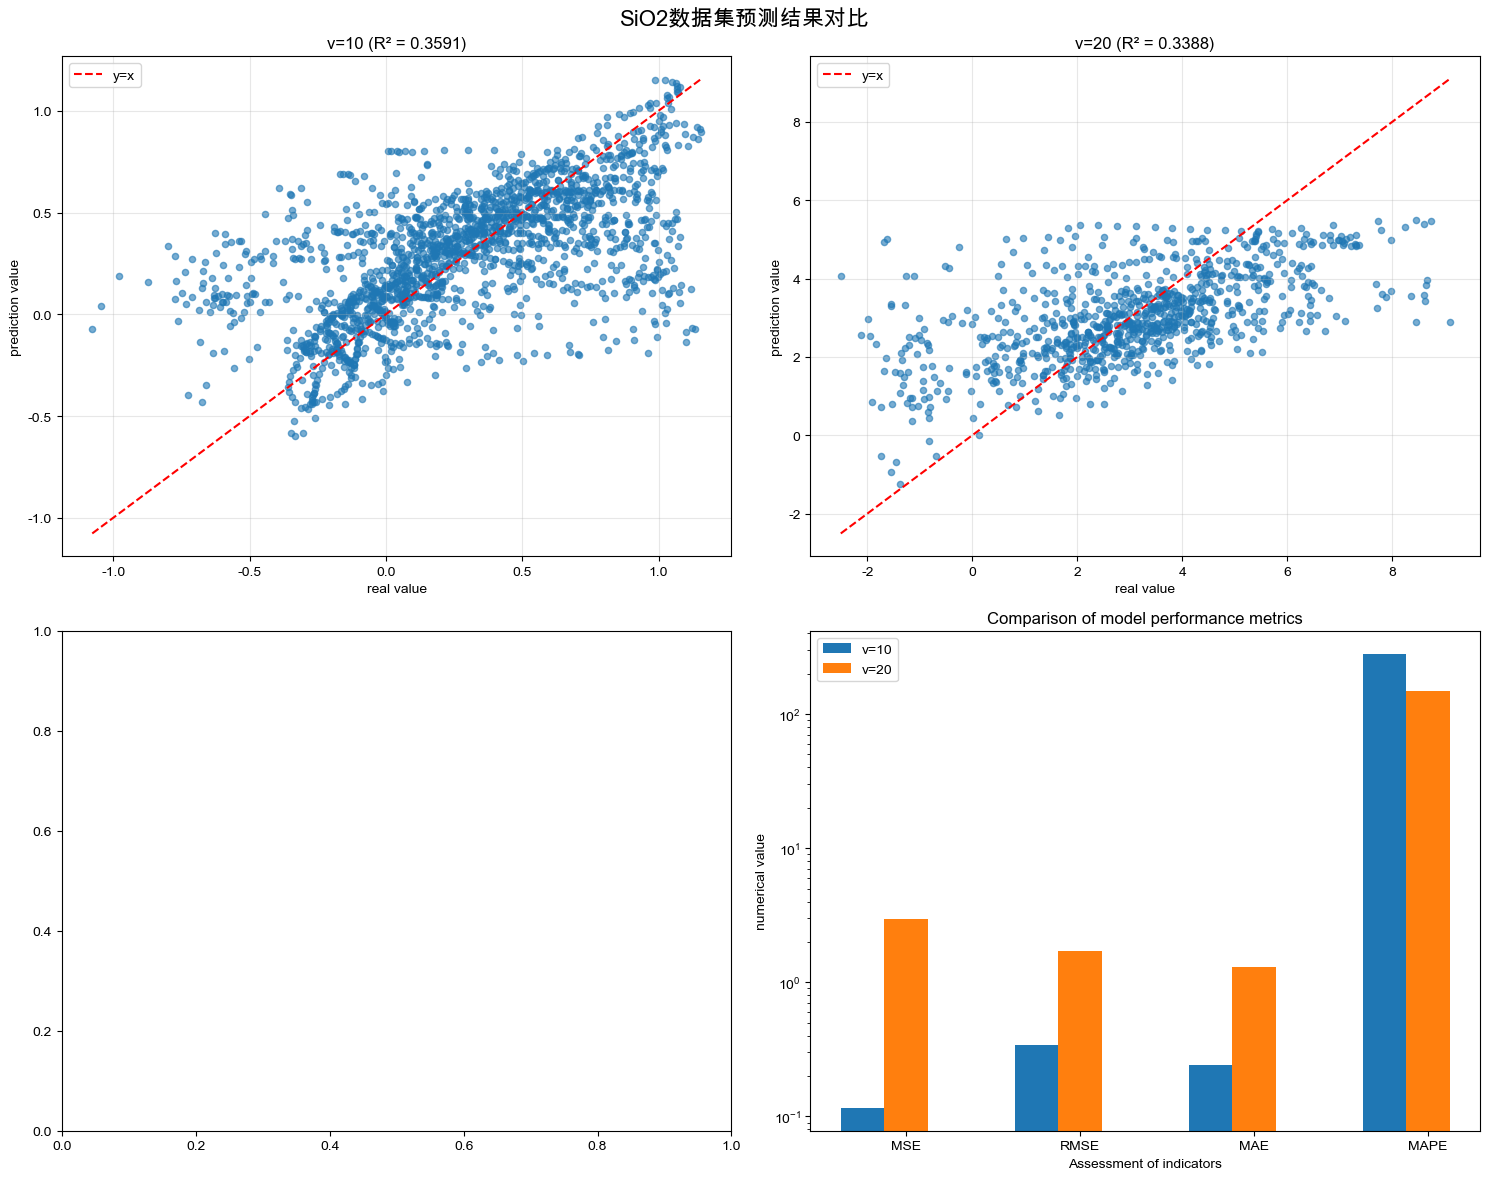

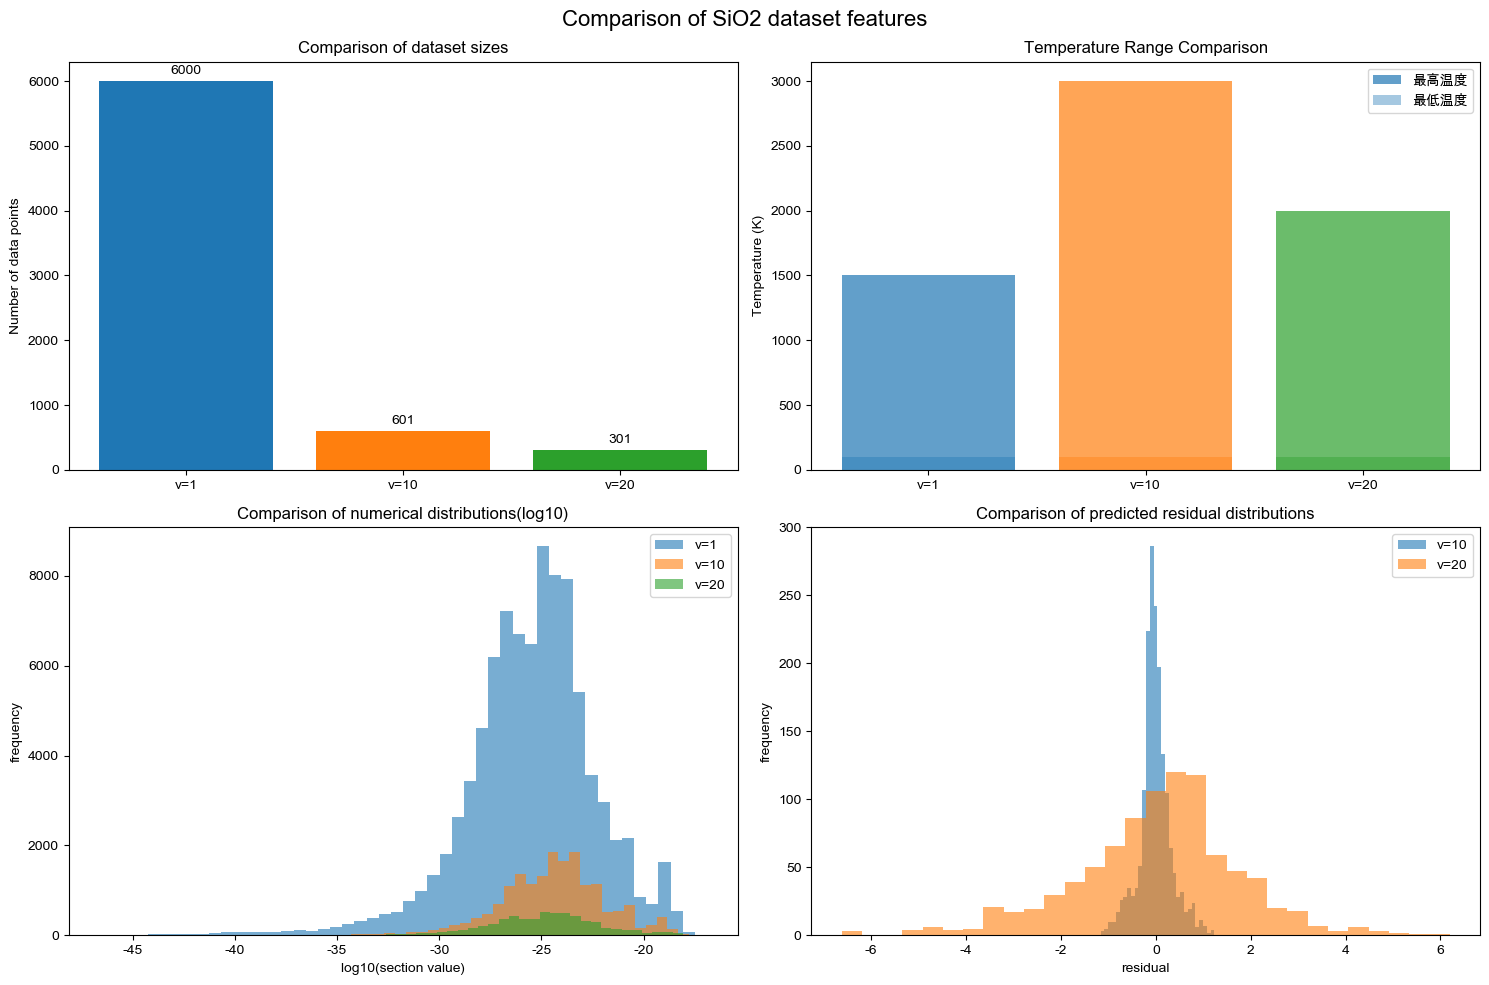


保存结果
  ✓ 保存Excel结果文件: sio2_comparison_results.xlsx

分析完成！
生成的文件:
  - sio2_comparison_results.png: 预测结果对比图
  - sio2_dataset_comparison.png: 数据集特征对比图
  - sio2_comparison_results.xlsx: 详细结果Excel文件

建议:
  - 最佳模型: v=10 (R² = 0.3591)
  - 查看生成的图表了解数据集差异
  - 检查Excel文件获取详细数值结果


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gmean
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def make_poly_mlp(model, degree=2):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        model
    )


class SiO2DataAnalyzer:
    def __init__(self):
        self.datasets = {}
        self.processed_data = {}
        self.models = {}
        self.results = {}
        
    def load_data(self):
        """加载三个SiO2数据集"""
        try:
            self.datasets['v=1'] = pd.read_excel('sio2_v=1.xlsm')
            self.datasets['v=10'] = pd.read_excel('sio2_v=10.xlsm')
            self.datasets['v=20'] = pd.read_excel('sio2_v=20.xlsm')
            print("✓ 成功加载所有SiO2数据集")
        except Exception as e:
            print(f"❌ 数据加载失败: {e}")
            return False
        return True
    
    def basic_info_comparison(self):
        """基本信息对比"""
        print("\n" + "="*60)
        print("SiO2数据集基本信息对比")
        print("="*60)
        
        for name, df in self.datasets.items():
            print(f"\n{name} 数据集:")
            print(f"  - 数据形状: {df.shape}")
            print(f"  - 波数范围: {df['wavenumber'].min():.0f} - {df['wavenumber'].max():.0f} cm⁻¹")
            print(f"  - 温度列数: {len([col for col in df.columns if col.startswith('t=')])}")            
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            if temp_cols:
                temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                print(f"  - 温度范围: {min(temps)} - {max(temps)} K")
            
            # 数据统计
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 1:
                data_values = df[numeric_cols[1:]].values.flatten()
                data_values = data_values[~np.isnan(data_values)]
                if len(data_values) > 0:
                    print(f"  - 数值范围: {data_values.min():.2e} - {data_values.max():.2e}")
                    print(f"  - 平均值: {data_values.mean():.2e}")
    
    def preprocess_data(self):
        """数据预处理和标准化"""
        print("\n" + "="*60)
        print("数据预处理")
        print("="*60)
        
        for name, df in self.datasets.items():
            print(f"\n处理 {name} 数据集...")
            
            # 获取温度列
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            
            # 分离训练和测试数据
            test_cols = ['t=1800k', 't=1900k', 't=2000k']
            available_test_cols = [col for col in test_cols if col in temp_cols]
            train_cols = [col for col in temp_cols if col not in test_cols]
            
            if not train_cols:
                print(f"  ❌ {name}: 没有找到训练数据列")
                continue
                
            # 数据标准化
            train_data = df[train_cols].copy()
            row_means = train_data.mean(axis=1)
            row_stds = train_data.std(axis=1)
            
            # 避免除零
            row_stds = row_stds.replace(0, 1e-10)
            
            # 标准化训练数据
            train_scaled = train_data.subtract(row_means, axis=0).divide(row_stds, axis=0)
            
            # 处理测试数据
            test_data = None
            if available_test_cols:
                test_data = df[available_test_cols].copy()
                test_scaled = test_data.subtract(row_means, axis=0).divide(row_stds, axis=0)
            
            # 转换为长格式
            train_df = pd.concat([df[['wavenumber']], train_scaled], axis=1)
            train_long = pd.melt(
                train_df,
                id_vars='wavenumber',
                value_vars=train_cols,
                var_name='temperature',
                value_name='cross_section'
            )
            
            # 清理温度列
            train_long['temperature'] = train_long['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).str.replace('K', '', regex=False)
            train_long['temperature'] = train_long['temperature'].astype(int)
            
            processed_item = {
                'train_long': train_long,
                'row_means': row_means,
                'row_stds': row_stds,
                'original_df': df
            }
            
            if test_data is not None:
                test_df = pd.concat([df[['wavenumber']], test_scaled], axis=1)
                test_long = pd.melt(
                    test_df,
                    id_vars='wavenumber',
                    value_vars=available_test_cols,
                    var_name='temperature',
                    value_name='cross_section'
                )
                test_long['temperature'] = test_long['temperature'].str.replace('t=', '', regex=False).str.replace('k', '', regex=False).astype(int)
                processed_item['test_long'] = test_long
            
            self.processed_data[name] = processed_item
            print(f"  ✓ {name}: 训练数据 {len(train_long)} 行")
            if test_data is not None:
                print(f"    测试数据 {len(test_long)} 行")
    
    def train_models(self):
        """训练机器学习模型"""
        print("\n" + "="*60)
        print("模型训练")
        print("="*60)
        
        degree = 6
        alpha = 1.0
        
        for name, data in self.processed_data.items():
            print(f"\n训练 {name} 模型...")
            
            train_long = data['train_long']
            X_train = train_long[['wavenumber', 'temperature']]
            y_train = train_long['cross_section']
            
            # 创建多项式回归模型
            model = make_poly_mlp(
                    MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000, random_state=1),
                    degree=2
                )
            # 训练模型
            model.fit(X_train, y_train)
            self.models[name] = model
            
            # 如果有测试数据，进行预测和评估
            if 'test_long' in data:
                test_long = data['test_long']
                X_test = test_long[['wavenumber', 'temperature']]
                y_test = test_long['cross_section']
                y_pred = model.predict(X_test)
                
                # 计算评估指标
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
                gme = gmean(np.abs(y_test - y_pred) + 1e-8)
                
                self.results[name] = {
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'mape': mape,
                    'gme': gme,
                    'y_test': y_test,
                    'y_pred': y_pred
                }
                
                print(f"  ✓ {name} 模型性能:")
                print(f"    MSE: {mse:.4e}")
                print(f"    RMSE: {rmse:.4e}")
                print(f"    MAE: {mae:.4e}")
                print(f"    R²: {r2:.4f}")
                print(f"    MAPE: {mape:.2f}%")
                print(f"    GME: {gme:.4e}")
            else:
                print(f"  ✓ {name} 模型训练完成（无测试数据）")
    
    def create_visualizations(self):
        """创建可视化图表"""
        print("\n" + "="*60)
        print("生成可视化图表")
        print("="*60)
        
        # 1. 预测结果散点图对比
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('SiO2数据集预测结果对比', fontsize=16, fontweight='bold')
        
        plot_idx = 0
        for name, result in self.results.items():
            if plot_idx < 3:
                row, col = plot_idx // 2, plot_idx % 2
                ax = axes[row, col]
                
                y_test = result['y_test']
                y_pred = result['y_pred']
                
                ax.scatter(y_test, y_pred, alpha=0.6, s=20)
                ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y=x')
                ax.set_xlabel('real value')
                ax.set_ylabel('prediction value')
                ax.set_title(f'{name} (R² = {result["r2"]:.4f})')
                ax.legend()
                ax.grid(True, alpha=0.3)
                plot_idx += 1
        
        # 性能指标对比
        if len(self.results) > 1:
            ax = axes[1, 1]
            metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']
            x_pos = np.arange(len(metrics))
            width = 0.25
            
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            for i, (name, result) in enumerate(self.results.items()):
                values = [result['mse'], result['rmse'], result['mae'], result['mape']]
                ax.bar(x_pos + i*width, values, width, label=name, color=colors[i % len(colors)])
            
            ax.set_xlabel('Assessment of indicators')
            ax.set_ylabel('numerical value')
            ax.set_title('Comparison of model performance metrics')
            ax.set_xticks(x_pos + width)
            ax.set_xticklabels(metrics)
            ax.legend()
            ax.set_yscale('log')
        
        plt.tight_layout()
        plt.savefig('sio2_comparison_results.png', dpi=300, bbox_inches='tight')
        print("  ✓ Save the comparison chart of prediction results: sio2_comparison_results.png")
        
        # 2. 数据集规模和分布对比
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Comparison of SiO2 dataset features', fontsize=16, fontweight='bold')
        
        # 数据集大小对比
        ax1 = axes[0, 0]
        names = list(self.datasets.keys())
        sizes = [df.shape[0] for df in self.datasets.values()]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        bars = ax1.bar(names, sizes, color=colors)
        ax1.set_title('Comparison of dataset sizes')
        ax1.set_ylabel('Number of data points')
        for bar, size in zip(bars, sizes):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.01, 
                    str(size), ha='center', va='bottom')
        
        # 温度范围对比
        ax2 = axes[0, 1]
        temp_ranges = []
        for name, df in self.datasets.items():
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            if temp_cols:
                temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                temp_ranges.append((min(temps), max(temps)))
            else:
                temp_ranges.append((0, 0))
        
        x_pos = np.arange(len(names))
        min_temps = [r[0] for r in temp_ranges]
        max_temps = [r[1] for r in temp_ranges]
        
        ax2.bar(x_pos, max_temps, color=colors, alpha=0.7, label='最高温度')
        ax2.bar(x_pos, min_temps, color=colors, alpha=0.4, label='最低温度')
        ax2.set_title('Temperature Range Comparison')
        ax2.set_ylabel('Temperature (K)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(names)
        ax2.legend()
        
        # 数值分布对比
        ax3 = axes[1, 0]
        for i, (name, df) in enumerate(self.datasets.items()):
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 1:
                data_values = df[numeric_cols[1:]].values.flatten()
                data_values = data_values[~np.isnan(data_values)]
                if len(data_values) > 0:
                    ax3.hist(np.log10(data_values + 1e-50), bins=50, alpha=0.6, 
                            label=name, color=colors[i])
        ax3.set_title('Comparison of numerical distributions(log10)')
        ax3.set_xlabel('log10(section value)')
        ax3.set_ylabel('frequency')
        ax3.legend()
        
        # 残差分布对比
        ax4 = axes[1, 1]
        for i, (name, result) in enumerate(self.results.items()):
            residuals = result['y_test'] - result['y_pred']
            ax4.hist(residuals, bins=30, alpha=0.6, label=name, color=colors[i])
        ax4.set_title('Comparison of predicted residual distributions')
        ax4.set_xlabel('residual')
        ax4.set_ylabel('frequency')
        ax4.legend()
        
        plt.tight_layout()
        plt.savefig('sio2_dataset_comparison.png', dpi=300, bbox_inches='tight')
        print("  ✓ Save the dataset feature comparison chart: sio2_dataset_comparison.png")
        
        plt.show()
    
    def save_results_to_excel(self):
        """保存结果到Excel文件"""
        print("\n" + "="*60)
        print("保存结果")
        print("="*60)
        
        with pd.ExcelWriter('sio2_comparison_results.xlsx', engine='openpyxl') as writer:
            # 基本信息汇总
            summary_data = []
            for name, df in self.datasets.items():
                temp_cols = [col for col in df.columns if col.startswith('t=')]
                temps = []
                if temp_cols:
                    temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                data_values = df[numeric_cols[1:]].values.flatten() if len(numeric_cols) > 1 else []
                data_values = data_values[~np.isnan(data_values)] if len(data_values) > 0 else []
                
                summary_data.append({
                    '数据集': name,
                    '数据点数': df.shape[0],
                    '特征数': df.shape[1],
                    '最低温度(K)': min(temps) if temps else 'N/A',
                    '最高温度(K)': max(temps) if temps else 'N/A',
                    '最小值': f"{data_values.min():.2e}" if len(data_values) > 0 else 'N/A',
                    '最大值': f"{data_values.max():.2e}" if len(data_values) > 0 else 'N/A',
                    '平均值': f"{data_values.mean():.2e}" if len(data_values) > 0 else 'N/A'
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='数据集概览', index=False)
            
            # 模型性能对比
            if self.results:
                performance_data = []
                for name, result in self.results.items():
                    performance_data.append({
                        '数据集': name,
                        'MSE': f"{result['mse']:.4e}",
                        'RMSE': f"{result['rmse']:.4e}",
                        'MAE': f"{result['mae']:.4e}",
                        'R²': f"{result['r2']:.4f}",
                        'MAPE(%)': f"{result['mape']:.2f}",
                        'GME': f"{result['gme']:.4e}"
                    })
                
                performance_df = pd.DataFrame(performance_data)
                performance_df.to_excel(writer, sheet_name='模型性能对比', index=False)
            
            # 保存原始数据
            for name, df in self.datasets.items():
                sheet_name = f'原始数据_{name.replace("=", "_")}'
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print("  ✓ 保存Excel结果文件: sio2_comparison_results.xlsx")
    
    def run_complete_analysis(self):
        """运行完整的对比分析"""
        print("开始SiO2数据集对比分析...")
        print("="*60)
        
        if not self.load_data():
            return
        
        self.basic_info_comparison()
        self.preprocess_data()
        self.train_models()
        self.create_visualizations()
        self.save_results_to_excel()
        
        print("\n" + "="*60)
        print("分析完成！")
        print("="*60)
        print("生成的文件:")
        print("  - sio2_comparison_results.png: 预测结果对比图")
        print("  - sio2_dataset_comparison.png: 数据集特征对比图")
        print("  - sio2_comparison_results.xlsx: 详细结果Excel文件")
        print("\n建议:")
        if self.results:
            best_model = max(self.results.items(), key=lambda x: x[1]['r2'])
            print(f"  - 最佳模型: {best_model[0]} (R² = {best_model[1]['r2']:.4f})")
        print("  - 查看生成的图表了解数据集差异")
        print("  - 检查Excel文件获取详细数值结果")

if __name__ == "__main__":
    analyzer = SiO2DataAnalyzer()
    analyzer.run_complete_analysis()

开始SiO2数据集对比分析...
✓ Successfully loaded all SiO2 datasets

SiO2 Dataset Basic Information Comparison

Dataset v=1:
  - Data shape: (6000, 16)
  - Wavenumber range: 0 - 5999 cm⁻¹
  - Number of temperature columns: 15
  - Temperature range: 100 - 1500 K
  - Value range: 2.27e-47 - 1.27e-17
  - Mean value: 6.07e-21

Dataset v=10:
  - Data shape: (601, 31)
  - Wavenumber range: 0 - 6000 cm⁻¹
  - Number of temperature columns: 30
  - Temperature range: 100 - 3000 K
  - Value range: 3.63e-45 - 1.71e-18
  - Mean value: 5.65e-21

Dataset v=20:
  - Data shape: (301, 21)
  - Wavenumber range: 0 - 6000 cm⁻¹
  - Number of temperature columns: 20
  - Temperature range: 100 - 2000 K
  - Value range: 6.98e-44 - 8.49e-19
  - Mean value: 5.95e-21

Data Preprocessing

Processing dataset v=1...
  ✓ v=1: Training data 72000 rows
    Test data 18000 rows

Processing dataset v=10...
  ✓ v=10: Training data 16227 rows
    Test data 1803 rows

Processing dataset v=20...
  ✓ v=20: Training data 5117 rows
    Te

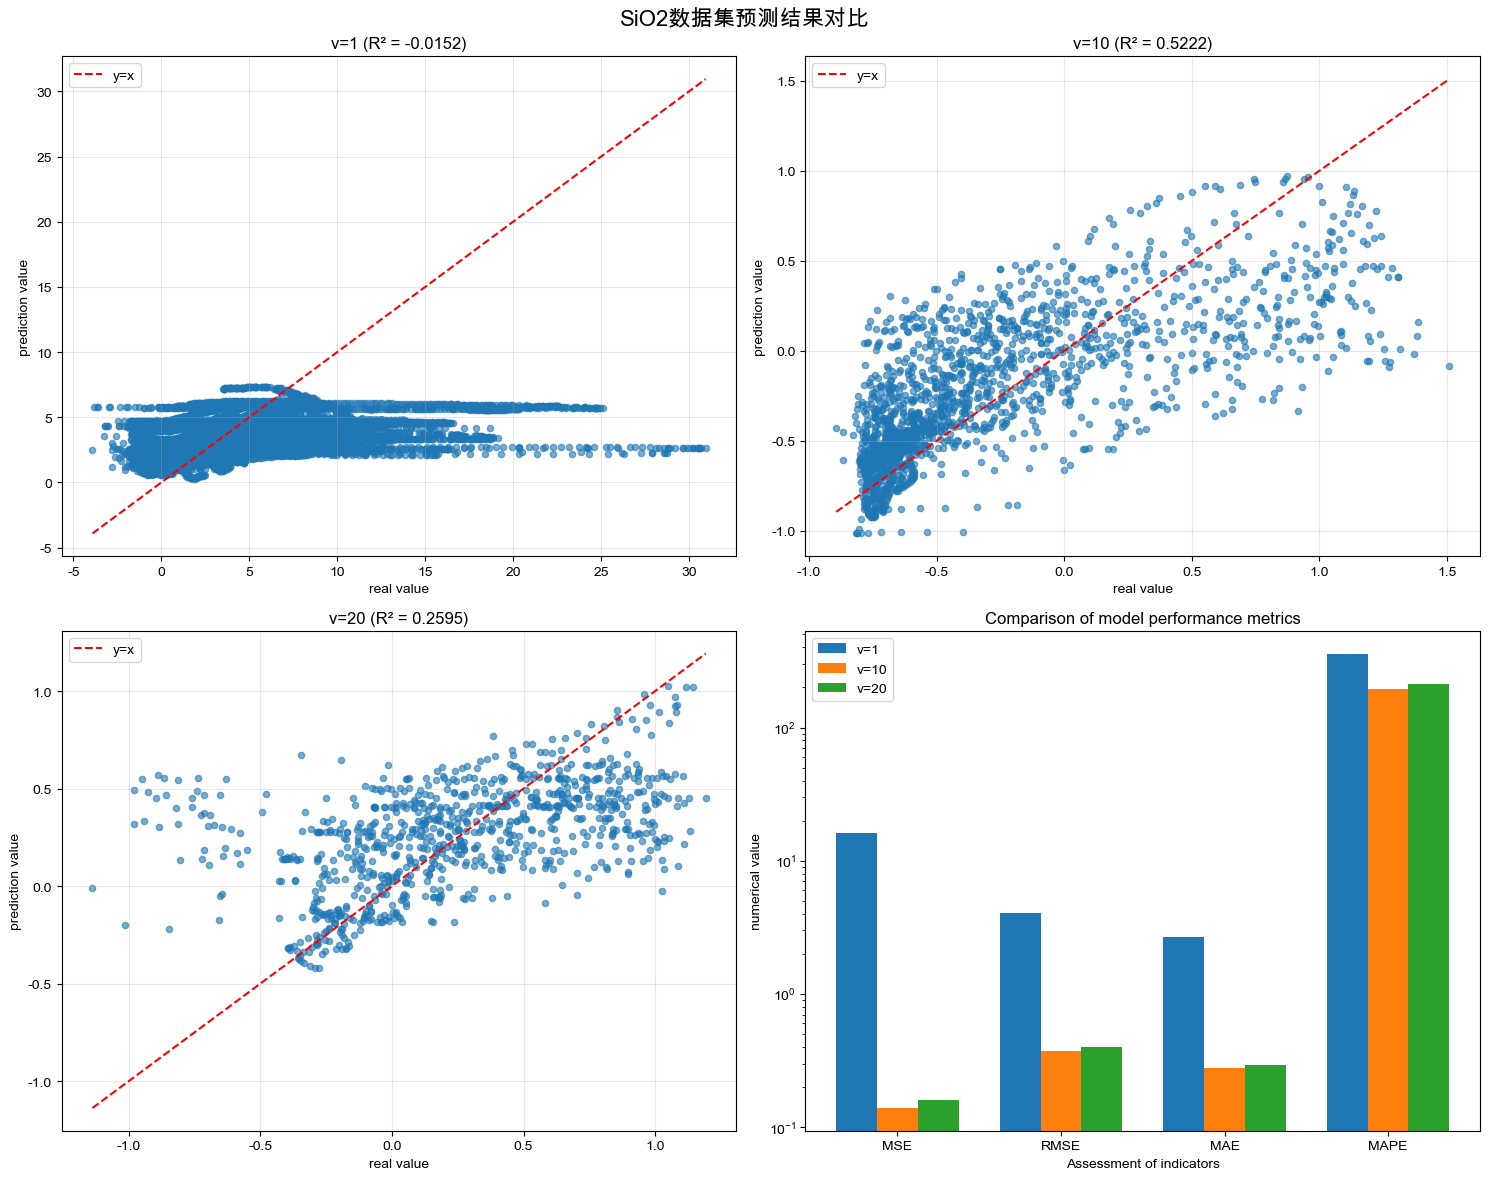

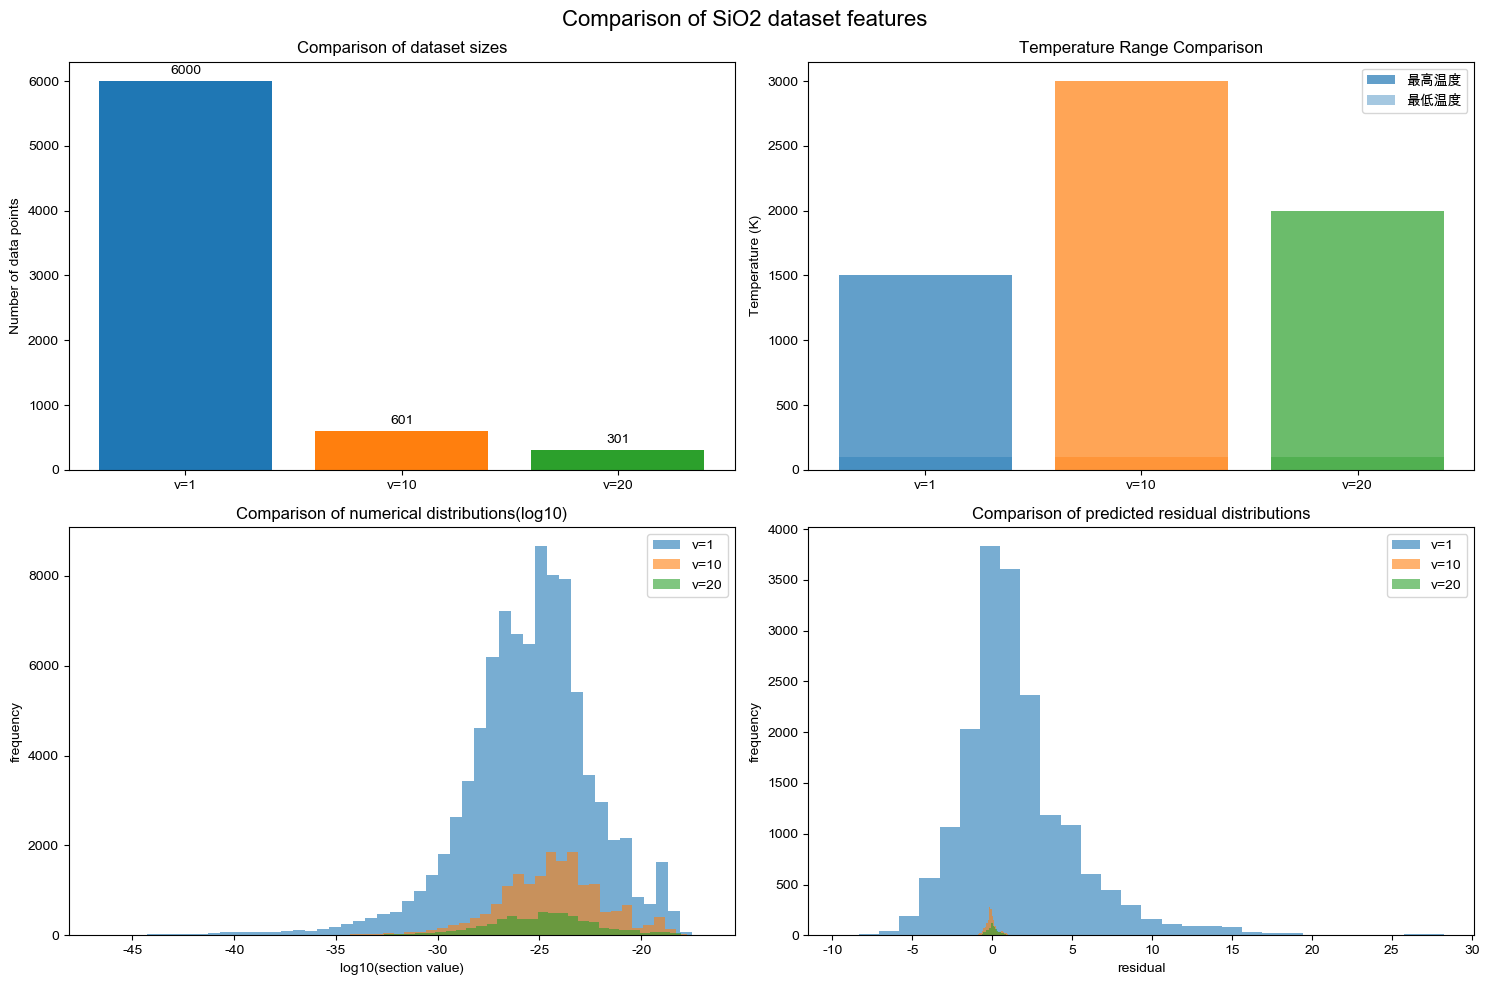


保存结果
  ✓ 保存Excel结果文件: sio2_comparison_results.xlsx

分析完成！
生成的文件:
  - sio2_comparison_results.png: 预测结果对比图
  - sio2_dataset_comparison.png: 数据集特征对比图
  - sio2_comparison_results.xlsx: 详细结果Excel文件

建议:
  - 最佳模型: v=10 (R² = 0.5222)
  - 查看生成的图表了解数据集差异
  - 检查Excel文件获取详细数值结果


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gmean
from sklearn.neural_network import MLPRegressor
import warnings

warnings.filterwarnings('ignore')

# Set font for plots (supporting Chinese and Unicode)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

def make_poly_mlp(model, degree=2):
    return make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        StandardScaler(),
        model
    )

class SiO2DataAnalyzer:
    def __init__(self):
        self.datasets = {}
        self.processed_data = {}
        self.models = {}
        self.results = {}
        
    def load_data(self):
        """Load three SiO2 datasets"""
        try:
            self.datasets['v=1'] = pd.read_excel('sio2_v=1.xlsm')
            self.datasets['v=10'] = pd.read_excel('sio2_v=10.xlsm')
            self.datasets['v=20'] = pd.read_excel('sio2_v=20.xlsm')
            print("✓ Successfully loaded all SiO2 datasets")
        except Exception as e:
            print(f"❌ Data loading failed: {e}")
            return False
        return True
    
    def basic_info_comparison(self):
        """Basic information comparison"""
        print("\n" + "="*60)
        print("SiO2 Dataset Basic Information Comparison")
        print("="*60)
        
        for name, df in self.datasets.items():
            print(f"\nDataset {name}:")
            print(f"  - Data shape: {df.shape}")
            print(f"  - Wavenumber range: {df['wavenumber'].min():.0f} - {df['wavenumber'].max():.0f} cm⁻¹")
            temp_cols = [col for col in df.columns if col.lower().startswith('t=')]
            print(f"  - Number of temperature columns: {len(temp_cols)}")
            if temp_cols:
                temps = [int(col.lower().replace('t=', '').replace('k', '')) for col in temp_cols]
                print(f"  - Temperature range: {min(temps)} - {max(temps)} K")
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 1:
                data_values = df[numeric_cols[1:]].values.flatten()
                data_values = data_values[~np.isnan(data_values)]
                if len(data_values) > 0:
                    print(f"  - Value range: {data_values.min():.2e} - {data_values.max():.2e}")
                    print(f"  - Mean value: {data_values.mean():.2e}")
    
    def preprocess_data(self):
        """Data preprocessing and normalization"""
        print("\n" + "="*60)
        print("Data Preprocessing")
        print("="*60)
        
        for name, df in self.datasets.items():
            print(f"\nProcessing dataset {name}...")
            
            temp_cols = [col for col in df.columns if col.lower().startswith('t=')]
            
            test_cols = ['t=1300k', 't=1400k', 't=1500k']
            test_cols_lower = [c.lower() for c in test_cols]
            available_test_cols = [col for col in temp_cols if col.lower() in test_cols_lower]
            train_cols = [col for col in temp_cols if col.lower() not in test_cols_lower]
            
            if not train_cols:
                print(f"  ❌ {name}: No training data columns found")
                continue
                
            train_data = df[train_cols].copy()
            row_means = train_data.mean(axis=1)
            row_stds = train_data.std(axis=1).replace(0, 1e-10)  # Avoid division by zero
            
            train_scaled = train_data.subtract(row_means, axis=0).divide(row_stds, axis=0)
            
            test_data = None
            test_scaled = None
            if available_test_cols:
                test_data = df[available_test_cols].copy()
                test_scaled = test_data.subtract(row_means, axis=0).divide(row_stds, axis=0)
            
            train_df = pd.concat([df[['wavenumber']], train_scaled], axis=1)
            train_long = pd.melt(
                train_df,
                id_vars='wavenumber',
                value_vars=train_cols,
                var_name='temperature',
                value_name='cross_section'
            )
            
            train_long['temperature'] = train_long['temperature'].str.lower().str.replace('t=', '').str.replace('k', '').astype(int)
            
            processed_item = {
                'train_long': train_long,
                'row_means': row_means,
                'row_stds': row_stds,
                'original_df': df
            }
            
            if test_data is not None and test_scaled is not None:
                test_df = pd.concat([df[['wavenumber']], test_scaled], axis=1)
                test_long = pd.melt(
                    test_df,
                    id_vars='wavenumber',
                    value_vars=available_test_cols,
                    var_name='temperature',
                    value_name='cross_section'
                )
                test_long['temperature'] = test_long['temperature'].str.lower().str.replace('t=', '').str.replace('k', '').astype(int)
                processed_item['test_long'] = test_long
            
            self.processed_data[name] = processed_item
            print(f"  ✓ {name}: Training data {len(train_long)} rows")
            if test_data is not None:
                print(f"    Test data {len(test_long)} rows")
    
    def train_models(self):
        """Train machine learning models"""
        print("\n" + "="*60)
        print("Model Training")
        print("="*60)
        
        for name, data in self.processed_data.items():
            print(f"\nTraining model for dataset {name}...")
            
            train_long = data['train_long']
            X_train = train_long[['wavenumber', 'temperature']]
            y_train = train_long['cross_section']
            
            model = make_poly_mlp(
                MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000, random_state=1),
                degree=2
            )
            
            model.fit(X_train, y_train)
            self.models[name] = model
            
            if 'test_long' in data:
                test_long = data['test_long']
                X_test = test_long[['wavenumber', 'temperature']]
                y_test = test_long['cross_section']
                y_pred = model.predict(X_test)
                
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
                gme = gmean(np.abs(y_test - y_pred) + 1e-8)
                
                self.results[name] = {
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'mape': mape,
                    'gme': gme,
                    'y_test': y_test,
                    'y_pred': y_pred
                }
                
                print(f"  ✓ {name} Model performance:")
                print(f"    MSE: {mse:.4e}")
                print(f"    RMSE: {rmse:.4e}")
                print(f"    MAE: {mae:.4e}")
                print(f"    R²: {r2:.4f}")
                print(f"    MAPE: {mape:.2f}%")
                print(f"    GME: {gme:.4e}")
            else:
                print(f"  ✓ {name} Model training completed (no test data)")
    
    def create_visualizations(self):
        """创建可视化图表"""
        print("\n" + "="*60)
        print("生成可视化图表")
        print("="*60)
        
        # 1. 预测结果散点图对比
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('SiO2数据集预测结果对比', fontsize=16, fontweight='bold')
        
        plot_idx = 0
        for name, result in self.results.items():
            if plot_idx < 3:
                row, col = plot_idx // 2, plot_idx % 2
                ax = axes[row, col]
                
                y_test = result['y_test']
                y_pred = result['y_pred']
                
                ax.scatter(y_test, y_pred, alpha=0.6, s=20)
                ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='y=x')
                ax.set_xlabel('real value')
                ax.set_ylabel('prediction value')
                ax.set_title(f'{name} (R² = {result["r2"]:.4f})')
                ax.legend()
                ax.grid(True, alpha=0.3)
                plot_idx += 1
        
        # 性能指标对比
        if len(self.results) > 1:
            ax = axes[1, 1]
            metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']
            x_pos = np.arange(len(metrics))
            width = 0.25
            
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            for i, (name, result) in enumerate(self.results.items()):
                values = [result['mse'], result['rmse'], result['mae'], result['mape']]
                ax.bar(x_pos + i*width, values, width, label=name, color=colors[i % len(colors)])
            
            ax.set_xlabel('Assessment of indicators')
            ax.set_ylabel('numerical value')
            ax.set_title('Comparison of model performance metrics')
            ax.set_xticks(x_pos + width)
            ax.set_xticklabels(metrics)
            ax.legend()
            ax.set_yscale('log')
        
        plt.tight_layout()
        plt.savefig('sio2_comparison_results.png', dpi=300, bbox_inches='tight')
        print("  ✓ Save the comparison chart of prediction results: sio2_comparison_results.png")
        
        # 2. 数据集规模和分布对比
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Comparison of SiO2 dataset features', fontsize=16, fontweight='bold')
        
        # 数据集大小对比
        ax1 = axes[0, 0]
        names = list(self.datasets.keys())
        sizes = [df.shape[0] for df in self.datasets.values()]
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        bars = ax1.bar(names, sizes, color=colors)
        ax1.set_title('Comparison of dataset sizes')
        ax1.set_ylabel('Number of data points')
        for bar, size in zip(bars, sizes):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sizes)*0.01, 
                    str(size), ha='center', va='bottom')
        
        # 温度范围对比
        ax2 = axes[0, 1]
        temp_ranges = []
        for name, df in self.datasets.items():
            temp_cols = [col for col in df.columns if col.startswith('t=')]
            if temp_cols:
                temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                temp_ranges.append((min(temps), max(temps)))
            else:
                temp_ranges.append((0, 0))
        
        x_pos = np.arange(len(names))
        min_temps = [r[0] for r in temp_ranges]
        max_temps = [r[1] for r in temp_ranges]
        
        ax2.bar(x_pos, max_temps, color=colors, alpha=0.7, label='最高温度')
        ax2.bar(x_pos, min_temps, color=colors, alpha=0.4, label='最低温度')
        ax2.set_title('Temperature Range Comparison')
        ax2.set_ylabel('Temperature (K)')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(names)
        ax2.legend()
        
        # 数值分布对比
        ax3 = axes[1, 0]
        for i, (name, df) in enumerate(self.datasets.items()):
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 1:
                data_values = df[numeric_cols[1:]].values.flatten()
                data_values = data_values[~np.isnan(data_values)]
                if len(data_values) > 0:
                    ax3.hist(np.log10(data_values + 1e-50), bins=50, alpha=0.6, 
                            label=name, color=colors[i])
        ax3.set_title('Comparison of numerical distributions(log10)')
        ax3.set_xlabel('log10(section value)')
        ax3.set_ylabel('frequency')
        ax3.legend()
        
        # 残差分布对比
        ax4 = axes[1, 1]
        for i, (name, result) in enumerate(self.results.items()):
            residuals = result['y_test'] - result['y_pred']
            ax4.hist(residuals, bins=30, alpha=0.6, label=name, color=colors[i])
        ax4.set_title('Comparison of predicted residual distributions')
        ax4.set_xlabel('residual')
        ax4.set_ylabel('frequency')
        ax4.legend()
        
        plt.tight_layout()
        plt.savefig('sio2_dataset_comparison.png', dpi=300, bbox_inches='tight')
        print("  ✓ Save the dataset feature comparison chart: sio2_dataset_comparison.png")
        
        plt.show()
    
    def save_results_to_excel(self):
        """保存结果到Excel文件"""
        print("\n" + "="*60)
        print("保存结果")
        print("="*60)
        
        with pd.ExcelWriter('sio2_comparison_results.xlsx', engine='openpyxl') as writer:
            # 基本信息汇总
            summary_data = []
            for name, df in self.datasets.items():
                temp_cols = [col for col in df.columns if col.startswith('t=')]
                temps = []
                if temp_cols:
                    temps = [int(col.replace('t=', '').replace('k', '').replace('K', '')) for col in temp_cols]
                
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                data_values = df[numeric_cols[1:]].values.flatten() if len(numeric_cols) > 1 else []
                data_values = data_values[~np.isnan(data_values)] if len(data_values) > 0 else []
                
                summary_data.append({
                    '数据集': name,
                    '数据点数': df.shape[0],
                    '特征数': df.shape[1],
                    '最低温度(K)': min(temps) if temps else 'N/A',
                    '最高温度(K)': max(temps) if temps else 'N/A',
                    '最小值': f"{data_values.min():.2e}" if len(data_values) > 0 else 'N/A',
                    '最大值': f"{data_values.max():.2e}" if len(data_values) > 0 else 'N/A',
                    '平均值': f"{data_values.mean():.2e}" if len(data_values) > 0 else 'N/A'
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='数据集概览', index=False)
            
            # 模型性能对比
            if self.results:
                performance_data = []
                for name, result in self.results.items():
                    performance_data.append({
                        '数据集': name,
                        'MSE': f"{result['mse']:.4e}",
                        'RMSE': f"{result['rmse']:.4e}",
                        'MAE': f"{result['mae']:.4e}",
                        'R²': f"{result['r2']:.4f}",
                        'MAPE(%)': f"{result['mape']:.2f}",
                        'GME': f"{result['gme']:.4e}"
                    })
                
                performance_df = pd.DataFrame(performance_data)
                performance_df.to_excel(writer, sheet_name='模型性能对比', index=False)
            
            # 保存原始数据
            for name, df in self.datasets.items():
                sheet_name = f'原始数据_{name.replace("=", "_")}'
                df.to_excel(writer, sheet_name=sheet_name, index=False)
        
        print("  ✓ 保存Excel结果文件: sio2_comparison_results.xlsx")
    
    def run_complete_analysis(self):
        """运行完整的对比分析"""
        print("开始SiO2数据集对比分析...")
        print("="*60)
        
        if not self.load_data():
            return
        
        self.basic_info_comparison()
        self.preprocess_data()
        self.train_models()
        self.create_visualizations()
        self.save_results_to_excel()
        
        print("\n" + "="*60)
        print("分析完成！")
        print("="*60)
        print("生成的文件:")
        print("  - sio2_comparison_results.png: 预测结果对比图")
        print("  - sio2_dataset_comparison.png: 数据集特征对比图")
        print("  - sio2_comparison_results.xlsx: 详细结果Excel文件")
        print("\n建议:")
        if self.results:
            best_model = max(self.results.items(), key=lambda x: x[1]['r2'])
            print(f"  - 最佳模型: {best_model[0]} (R² = {best_model[1]['r2']:.4f})")
        print("  - 查看生成的图表了解数据集差异")
        print("  - 检查Excel文件获取详细数值结果")

if __name__ == "__main__":
    analyzer = SiO2DataAnalyzer()
    analyzer.run_complete_analysis()